In [1]:
"""Pytorch."""
import nltk
import numpy as np
from numpy.typing import NDArray
import torch
from typing import List, Optional
from torch import nn
import matplotlib.pyplot as plt


FloatArray = NDArray[np.float64]


def onehot(vocabulary: List[Optional[str]], token: Optional[str]) -> FloatArray:
    """Generate the one-hot encoding for the provided token in the provided vocabulary."""
    embedding = np.zeros((len(vocabulary), 1))
    try:
        idx = vocabulary.index(token)
    except ValueError:
        idx = len(vocabulary) - 1
    embedding[idx, 0] = 1
    return embedding


def logit(x: FloatArray) -> FloatArray:
    """Compute logit (inverse sigmoid)."""
    return np.log(x) - np.log(1 - x)


def normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize vector so that it sums to 1."""
    return x / torch.sum(x)


def loss_fn(p: float) -> float:
    """Compute loss to maximize probability."""
    return -p


class Unigram(nn.Module):
    def __init__(self, V: int):
        super().__init__()

        # construct initial s - corresponds to uniform p
        s0 = logit(np.ones((V, 1)) / V)
        self.s = nn.Parameter(torch.tensor(s0.astype("float32")))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        # convert s to proper distribution p
        p = normalize(torch.sigmoid(self.s))

        # compute log probability of input
        return torch.sum(input, 1, keepdim=True).T @ torch.log(p), p

In [14]:
def gradient_descent_example():
    """Demonstrate gradient descent."""
    # generate vocabulary
    vocabulary = [chr(i + ord("a")) for i in range(26)] + [" ", None]

    # generate training document
    text = nltk.corpus.gutenberg.raw("austen-sense.txt").lower()

    # tokenize - split the document into a list of little strings
    tokens = [char for char in text]

    # generate one-hot encodings - a V-by-T array
    encodings = np.hstack([onehot(vocabulary, token) for token in tokens])

    # convert training data to PyTorch tensor
    x = torch.tensor(encodings.astype("float32"))

    # define model

    model = Unigram(len(vocabulary))

    # set number of iterations and learning rate
    num_iterations = 60
    learning_rate = 0.2

    # train model
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    list_loss = []
    list_items = []
    for i in range(num_iterations):
        p_pred, p = model(x)
        loss = -p_pred
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        list_loss.append(i)
        list_items.append(loss.item())
    true_p = torch.sum(x, 1, keepdim=True) / len(text)
    mm = -(torch.sum(x, 1, keepdim=True)).T @ torch.log(true_p)
    min = mm.item()
    # graph 1
    plt.plot(list_loss, list_items)
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.title("Loss as a function of time ")
    plt.axhline(y=min, color="red", linestyle="--", label="Minimum possible loss")
    plt.legend()
    plt.show()
    plt.savefig("graph 1.png", dpi=300, bbox_inches="tight")
    # graph 2
    plt.scatter(
        [str(i) for i in vocabulary],
        true_p.squeeze().tolist(),
        color="blue",
        alpha=0.4,
        label="Token probabilites",
    )
    plt.scatter(
        [str(i) for i in vocabulary],
        p.squeeze().tolist(),
        color="orange",
        alpha=1,
        marker="^",
        label="known probabilites",
    )
    plt.xlabel("Vocabulary")
    plt.ylabel("Probability")
    plt.title("Final token probabilities")
    plt.legend()
    plt.show
    plt.savefig("graph 2.png", dpi=300, bbox_inches="tight")

    # prob differences
    plt.figure()
    difference_list = [x - y for x, y in zip(true_p, p)]
    values_list = [tensor.item() for tensor in difference_list]
    plt.scatter([str(i) for i in vocabulary], values_list, color="green")
    plt.title("Difference in probabilities")
    plt.xlabel("Vocabulary")
    plt.ylabel("Difference in probability")
    plt.show

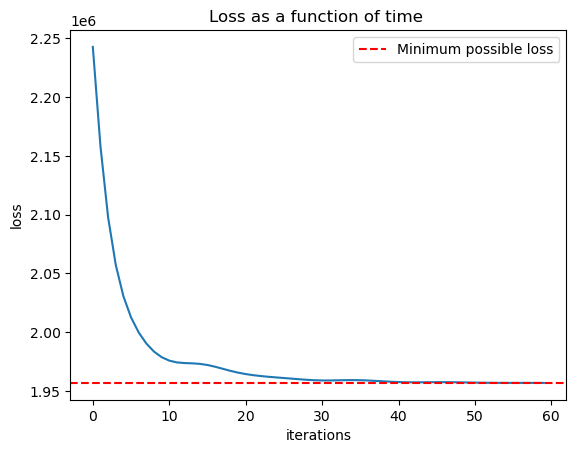

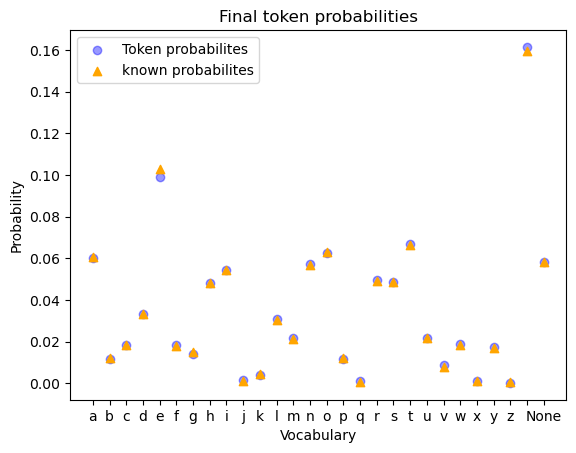

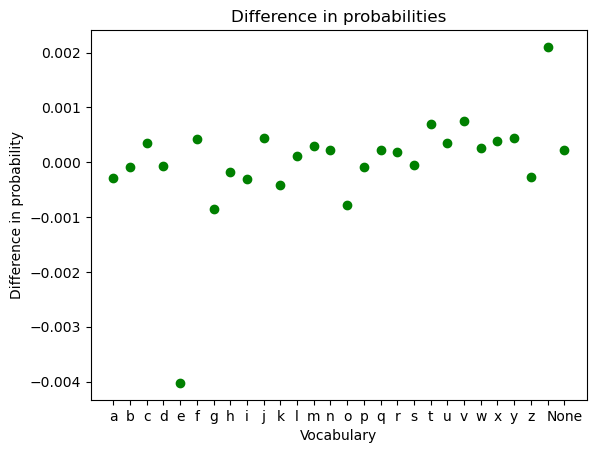

In [15]:
gradient_descent_example()